# N-Stage rocket performance calculator

In [315]:
import pandas as pd
import numpy as np

In [316]:
DEFAULT_2_STAGE_ROCKET_VALUES=[
    {'specific_impulse[m/s2]': 3000, 'total_mass[kg]': 10000, 'propelant_mass[kg]': 6272, 'propelant_consumption[kg/s]': 200},
    {'specific_impulse[m/s2]': 2300, 'total_mass[kg]': 2160, 'propelant_mass[kg]': 1568, 'propelant_consumption[kg/s]': 60},
    # {'specific_impulse[m/s2]': 1200, 'total_mass[kg]': 1105, 'propelant_mass[kg]': 800, 'propelant_consumption[kg/s]': 30},
    # {'specific_impulse[m/s2]': 600, 'total_mass[kg]': 500, 'propelant_mass[kg]': 300, 'propelant_consumption[kg/s]': 10},
]
for i in DEFAULT_2_STAGE_ROCKET_VALUES:
    i['mass_number'] = i['total_mass[kg]'] / (i['total_mass[kg]']-i['propelant_mass[kg]'])

print(DEFAULT_2_STAGE_ROCKET_VALUES)

[{'specific_impulse[m/s2]': 3000, 'total_mass[kg]': 10000, 'propelant_mass[kg]': 6272, 'propelant_consumption[kg/s]': 200, 'mass_number': 2.6824034334763946}, {'specific_impulse[m/s2]': 2300, 'total_mass[kg]': 2160, 'propelant_mass[kg]': 1568, 'propelant_consumption[kg/s]': 60, 'mass_number': 3.6486486486486487}]


In [317]:
g0 = 9.81 # m/s^2

NUM_STAGES = int(input("How many stages does your rocket have? [< 8] (Just press 'ENTER' for default values)").strip() or len(DEFAULT_2_STAGE_ROCKET_VALUES))
if NUM_STAGES < 1 or NUM_STAGES > 8:
    raise ValueError("Invalid number of stages")
print("Your rocket has", NUM_STAGES, "stages.")

Your rocket has 2 stages.


In [318]:
STAGES_VALUES = []

for stage in range(NUM_STAGES):
    specific_impulse = float(input(f"Enter the specific impulse for stage {stage + 1} in [m/s2]: (Just press 'ENTER' for default values)").strip() or DEFAULT_2_STAGE_ROCKET_VALUES[stage]['specific_impulse[m/s2]'])
    total_mass = float(input(f"Enter the total mass for stage {stage + 1} in [kg]: (Just press 'ENTER' for default values)").strip() or DEFAULT_2_STAGE_ROCKET_VALUES[stage]['total_mass[kg]'])
    propelant_mass = float(input(f"Enter the propelant mass for stage {stage + 1} in [kg]: (Just press 'ENTER' for default values)").strip() or DEFAULT_2_STAGE_ROCKET_VALUES[stage]['propelant_mass[kg]'])
    propelant_consumption = float(input(f"Enter the propelant consumption rate for stage {stage + 1} in [kg/s]: (Just press 'ENTER' for default values)").strip() or DEFAULT_2_STAGE_ROCKET_VALUES[stage]['propelant_consumption[kg/s]'])
    final_stage_mass = total_mass - propelant_mass
    
    rocket_stage_parameters_dict = {
        'specific_impulse[m/s2]': specific_impulse,
        'total_mass[kg]': total_mass,
        'propelant_mass[kg]': propelant_mass,
        'propelant_consumption[kg/s]': propelant_consumption,
        'final_stage_mass[kg]': final_stage_mass,
        'mass_number': total_mass / (total_mass - propelant_mass),
    }
    STAGES_VALUES.append(rocket_stage_parameters_dict)

# Convert the list of dictionaries to a DataFrame
stages_values_df = pd.DataFrame(STAGES_VALUES)

# Display the DataFrame
print(stages_values_df)

   specific_impulse[m/s2]  total_mass[kg]  propelant_mass[kg]  \
0                  3000.0         10000.0              6272.0   
1                  2300.0          2160.0              1568.0   

   propelant_consumption[kg/s]  final_stage_mass[kg]  mass_number  
0                        200.0                3728.0     2.682403  
1                         60.0                 592.0     3.648649  


### For each stage calculate: 
- Time of combustion $t_f$   ...           $t_f = \frac{m_p}{\dot{m}_p} = \frac{m_0-m_f}{\dot{m}_p}$
- Increment of velocity $\Delta V_i$ ...   $\Delta V_i = V_f = I_{sp}ln(\frac{m_0}{m_f})-g_0\frac{m_0-m_f}{\dot{m}_p}$
- Increment of altitude $\Delta h_i$ ...   $\Delta h_i = \frac{I_{sp}}{\dot{m}_p}[(m_0-\dot{m}_pt)ln(\frac{m_0-\dot{m}_pt}{m_0})+\dot{m}_pt]-\frac{1}{2}g_0t^2$

In [319]:
STAGES_RESULTS = []

for stage in range(NUM_STAGES):
    time_of_combustion = STAGES_VALUES[stage]['propelant_mass[kg]'] / STAGES_VALUES[stage]['propelant_consumption[kg/s]']
    delta_v = STAGES_VALUES[stage]['specific_impulse[m/s2]'] * np.log(STAGES_VALUES[stage]['total_mass[kg]'] / STAGES_VALUES[stage]['final_stage_mass[kg]']) - g0 * ((STAGES_VALUES[stage]['total_mass[kg]']-STAGES_VALUES[stage]['final_stage_mass[kg]'])/STAGES_VALUES[stage]['propelant_consumption[kg/s]'])
    delta_h = (
        (STAGES_VALUES[stage]['specific_impulse[m/s2]'] / STAGES_VALUES[stage]['propelant_consumption[kg/s]']) *
        (
            (STAGES_VALUES[stage]['total_mass[kg]'] - STAGES_VALUES[stage]['propelant_consumption[kg/s]'] * time_of_combustion) * 
            np.log((STAGES_VALUES[stage]['total_mass[kg]'] - STAGES_VALUES[stage]['propelant_consumption[kg/s]'] * time_of_combustion) / STAGES_VALUES[stage]['total_mass[kg]']) + 
            STAGES_VALUES[stage]['propelant_consumption[kg/s]'] * time_of_combustion
            ) - 0.5 * g0 * time_of_combustion**2
        )
   
    result_to_append = {}
    if stage == 0:
        result_to_append = {
            'time_of_combustion[s]': time_of_combustion,
            'delta_v[m/s]': delta_v,
            'delta_h[m]': delta_h,
            'cumulative_burn_time[s]': time_of_combustion,
            'cumulative_vel[m/s]': delta_v,
            'cumulative_alt[m]': delta_h,
        }
    elif stage != 0:
        result_to_append = {
            'time_of_combustion[s]': time_of_combustion,
            'delta_v[m/s]': delta_v,
            'delta_h[m]': delta_h,
            'cumulative_burn_time[s]': STAGES_RESULTS[stage-1]['cumulative_burn_time[s]'] + time_of_combustion,
            'cumulative_vel[m/s]': STAGES_RESULTS[stage-1]['cumulative_vel[m/s]'] + delta_v,
            'cumulative_alt[m]': STAGES_RESULTS[stage-1]['cumulative_alt[m]'] + delta_h,
        }
    
    STAGES_RESULTS.append(result_to_append)     


# Convert the list of dictionaries to a DataFrame
stages_results_df = pd.DataFrame(STAGES_RESULTS).transpose()
# Display the DataFrame
print(stages_results_df)



                                    0             1
time_of_combustion[s]       31.360000     26.133333
delta_v[m/s]              2652.497989   2720.652791
delta_h[m]               34079.177782  27383.519659
cumulative_burn_time[s]     31.360000     57.493333
cumulative_vel[m/s]       2652.497989   5373.150780
cumulative_alt[m]        34079.177782  61462.697441


### Absolute rocket ceiling
<!-- Rocket stops at the moment $V(t=t_{max}) = 0$

This means ... $V_f - g_0(t_{max}-t_f) = 0 \rightarrow t_{max} = t_f + \frac{V_f}{g_0}$

Distance flown in time $\Delta t = t_{max}-t_f$:

$\Delta h = V_f\Delta t - \frac{1}{2} g_0\Delta t^2 = V_f( t_{max} -t_f) - \frac{1}{2} g_0(t_{max}-t_f)^2 $

Absolute ceiling is then:

$h_{max} = h_f + \Delta h = h_f + V_f(t_{max}-t_f) - \frac{1}{2} g_0(t_{max}-t_f)^2$

Finally we get:

$t_{max} = \frac{1}{g_0}(I_{sp}ln\mu-g_0 t_f) + t_f = \frac{I_{sp}}{g_0}ln\mu$

$h_{max} = I_{sp}\frac{m_f}{\dot{m}_p}(\mu-1-\mu ln \mu) + \frac{1}{2g_0}(I_{sp}ln\mu)^2$ -->

$ h_{max} = \frac{V_f^2}{2g_0} + h_f$

$ t_{max} = \frac{V_f}{g_0} + t_f$

In [320]:
h_max = stages_results_df.iloc[-2][NUM_STAGES-1]**2 / (2*g0) + stages_results_df.iloc[-1][NUM_STAGES-1]
print(f'MAXIMUM ALTITUDE REACHED BY ROCKET: {h_max:.2f} m')
print(f'                                 ~  {h_max/1000:.2f} km')
t_max = stages_results_df.iloc[-2][NUM_STAGES-1]/g0 + stages_results_df.iloc[-3][NUM_STAGES-1]
print(f'TIME TO REACH MAXIMUM ALTITUDE:     {t_max:.2f} s')

MAXIMUM ALTITUDE REACHED BY ROCKET: 1532958.58 m
                                 ~  1532.96 km
TIME TO REACH MAXIMUM ALTITUDE:     605.22 s


In [321]:
burn_finish_times = []
for stage in range(NUM_STAGES):
    if stage == 0:
        burn_finish_times.append(STAGES_RESULTS[stage]['time_of_combustion[s]'])
    elif stage > 0:
        burn_finish_times.append(burn_finish_times[stage-1] + STAGES_RESULTS[stage]['time_of_combustion[s]'])

SCALE_STEP = 0.3136
#SCALE_STEP = 0.1
time_scale = np.arange(0, burn_finish_times[-1], SCALE_STEP)
time_scale = np.sort(np.append(time_scale, burn_finish_times)).tolist()

### Altitude as a function of time
$ h(t) = \frac{I_{sp}}{\dot{m}_p}[(m_0-\dot{m}_pt)ln(\frac{m_0-\dot{m}_pt}{m_0})+\dot{m}_pt]-\frac{1}{2}g_0t^2$

### Velocity as a function of time
$ V(t) = I_{sp}ln(\frac{m_0}{m_0-\dot{m}_pt})-g_0t$

In [322]:
alt_in_time = dict.fromkeys(time_scale, 0)
vel_in_time = dict.fromkeys(time_scale, 0)
current_stage = 1
time_burning = 0
tmp_burn_finish_times = list(burn_finish_times)

for i in time_scale:
    if tmp_burn_finish_times != []:
        
        if i < tmp_burn_finish_times[0] and i != 0:
            if current_stage > 1:
                height_offset = float(stages_results_df.iloc[-1][current_stage-2])
                velocity_offset = float(stages_results_df.iloc[-2][current_stage-2])

            elif current_stage == 1:
                height_offset = 0
                velocity_offset = 0
            time_burning += SCALE_STEP

            alt_in_time[i] = height_offset+ float(
                (STAGES_VALUES[current_stage-1]['specific_impulse[m/s2]'] / STAGES_VALUES[current_stage-1]['propelant_consumption[kg/s]']) *
                (
                    (STAGES_VALUES[current_stage-1]['total_mass[kg]'] - STAGES_VALUES[current_stage-1]['propelant_consumption[kg/s]'] * time_burning) * 
                    np.log((STAGES_VALUES[current_stage-1]['total_mass[kg]'] - STAGES_VALUES[current_stage-1]['propelant_consumption[kg/s]'] * time_burning) / STAGES_VALUES[current_stage-1]['total_mass[kg]']) + 
                    STAGES_VALUES[current_stage-1]['propelant_consumption[kg/s]'] * time_burning
                    ) - 0.5 * g0 * time_burning**2
                )
            vel_in_time[i] = velocity_offset + float(
                STAGES_VALUES[current_stage-1]['specific_impulse[m/s2]'] * 
                np.log(
                    STAGES_VALUES[current_stage-1]['total_mass[kg]'] / 
                    (STAGES_VALUES[current_stage-1]['total_mass[kg]'] - STAGES_VALUES[current_stage-1]['propelant_consumption[kg/s]'] * time_burning)) - 
                    g0 * time_burning
            )

        elif i == tmp_burn_finish_times[0]:
            alt_in_time[i] = float(stages_results_df.iloc[-1][current_stage-1])
            vel_in_time[i] = float(stages_results_df.iloc[-2][current_stage-1])
            tmp_burn_finish_times.pop(0)
            current_stage += 1
            time_burning = 0

for b in burn_finish_times:
    del alt_in_time[b]
    del vel_in_time[b]

### Unpowered flight height
We calcultae $\Delta h$ for time increment $t$ using following formula:

$\Delta h = V_f(t_{max}-t_f) - \frac{1}{2} g_0(t_{max}-t_f)^2$

$V_f$ is final cumulative velocity obtained from the last burn.

$t_f$ end time of the last burn.

$t_{max}$ is the time when the rocket reaches the maximum altitude. $ t_{max} = \frac{V_f}{g_0} + t_f$

In [323]:
alt_unpowered_timeline = np.arange(burn_finish_times[-1], t_max, SCALE_STEP).tolist()
alt_extension_dict = dict.fromkeys(alt_unpowered_timeline, 0)
alt_in_time_unpowered_ext = alt_in_time.copy()
alt_in_time_unpowered_ext.update(alt_extension_dict)


for i in alt_unpowered_timeline:
    alt_in_time_unpowered_ext[i] = float(stages_results_df.iloc[-2][NUM_STAGES-1]*
                                    (i - stages_results_df.iloc[-3][NUM_STAGES-1]) - 
                                    0.5 * g0 * (i - stages_results_df.iloc[-3][NUM_STAGES-1])**2
                                    )

### Unpowered flight altitude
For the upowered part of the flight we use following equation:
$ V(t) = V_f - g_0(t - t_f)$

We get a velocity as a function of time $V(t)$ where $t$ is time increment from the time when last burn ended.

$V_f$ is final cumulative velocity obtained from the last burn.

$t_f$ end time of the last burn.


In [324]:
vel_unpowered_timeline = np.arange(burn_finish_times[-1], t_max, SCALE_STEP).tolist()
vel_extension_dict = dict.fromkeys(vel_unpowered_timeline, 0)
vel_in_time_unpowered_ext = vel_in_time.copy()
vel_in_time_unpowered_ext.update(vel_extension_dict)

for i in alt_unpowered_timeline:
    vel_in_time_unpowered_ext[i] = float(stages_results_df.iloc[-2][NUM_STAGES-1] - g0 * (i - stages_results_df.iloc[-3][NUM_STAGES-1]))

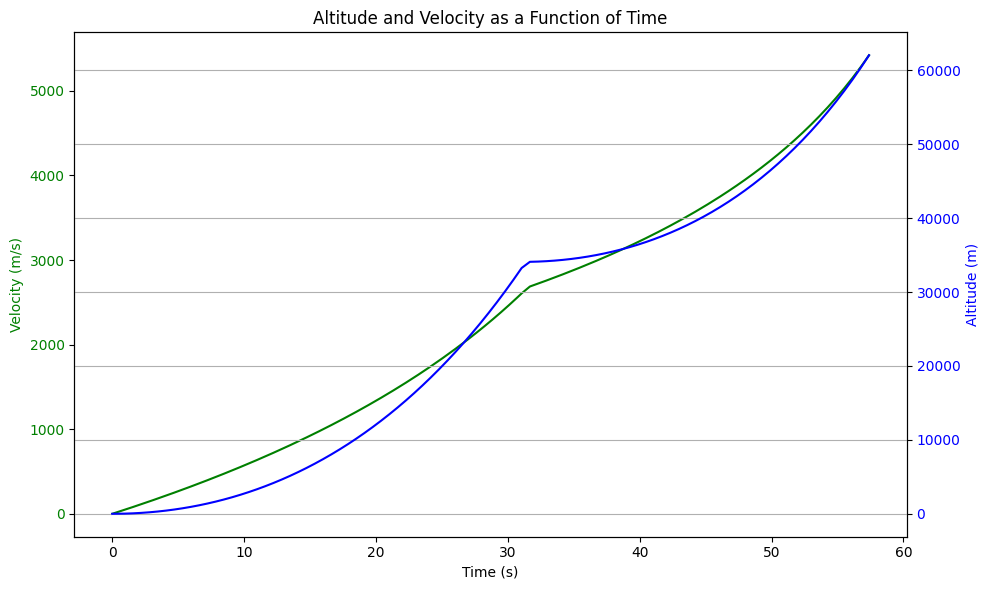

In [325]:
import matplotlib.pyplot as plt

# Extract time, altitude, and velocity values from the dictionaries
time_values = list(alt_in_time.keys())
altitude_values = list(alt_in_time.values())
velocity_values = list(vel_in_time.values())

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot velocity on the left y-axis
ax1.plot(time_values, velocity_values, 'g-', label='Velocity')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for altitude
ax2 = ax1.twinx()
ax2.plot(time_values, altitude_values, 'b-', label='Altitude')
ax2.set_ylabel('Altitude (m)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add a title and grid
plt.title('Altitude and Velocity as a Function of Time')
fig.tight_layout()
plt.grid(True)

# Show the plot
plt.show()

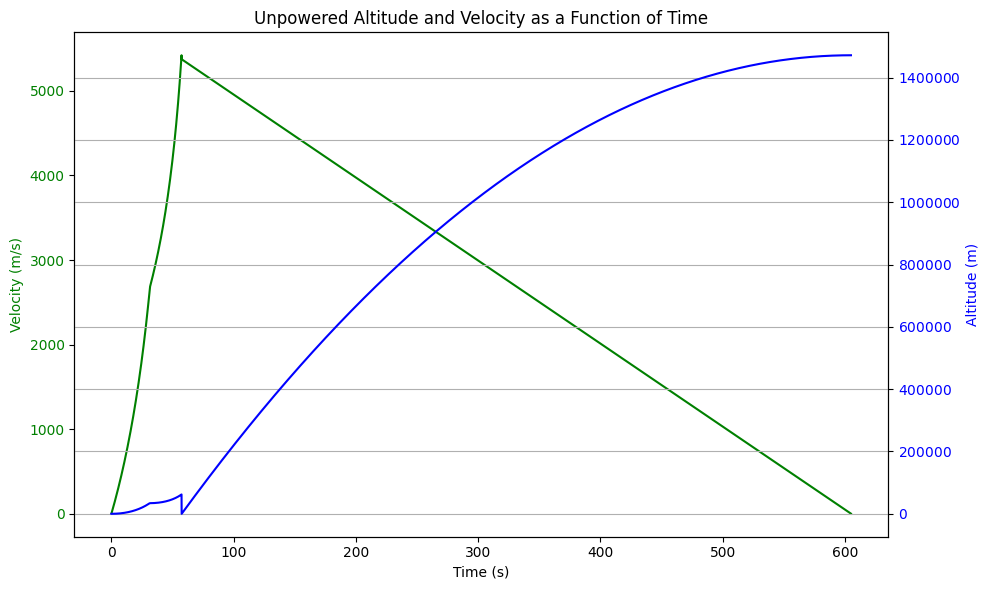

In [326]:
from matplotlib.ticker import ScalarFormatter
# Extract time, altitude, and velocity values from the dictionaries
time_values_unpowered = list(alt_in_time_unpowered_ext.keys())
altitude_values_unpowered = list(alt_in_time_unpowered_ext.values())
velocity_values_unpowered = list(vel_in_time_unpowered_ext.values())

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot velocity on the left y-axis
ax1.plot(time_values_unpowered, velocity_values_unpowered, 'g-', label='Velocity (Unpowered)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for altitude
ax2 = ax1.twinx()
ax2.plot(time_values_unpowered, altitude_values_unpowered, 'b-', label='Altitude (Unpowered)')
ax2.set_ylabel('Altitude (m)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Set the formatter for the right y-axis to avoid scientific notation
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style='plain', axis='y')

# Add a title and grid
plt.title('Unpowered Altitude and Velocity as a Function of Time')
fig.tight_layout()
plt.grid(True)

# Show the plot
plt.show()